# Montandon STAC API - Data Analysis and Visualization

This notebook demonstrates how to:
1. Connect to the Montandon STAC API
2. Query disaster event data from multiple collections
3. Analyze hazard codes and their distributions
4. Visualize disaster events using charts
5. Export data for further analysis

The Montandon STAC API provides access to disaster event data from multiple sources including GDACS, EM-DAT, and GLIDE.

## 1. Setup and Imports

First, let's import all necessary libraries and set up the connection to Montandon STAC API.


In [1]:
# Import all necessary libraries
import json
import pandas as pd
from pystac_client import Client
import pystac
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Any, Optional
import warnings

warnings.filterwarnings('ignore')

# Set display options for better readability
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 50)
pd.set_option('display.width', None)

# Plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("All libraries imported successfully!")

# Connect to Montandon STAC API using pystac_client
STAC_API_URL = "https://montandon-eoapi-stage.ifrc.org/stac"
client = Client.open(STAC_API_URL)

print(f"Connected to Montandon STAC API: {STAC_API_URL}")

All libraries imported successfully!
Connected to Montandon STAC API: https://montandon-eoapi-stage.ifrc.org/stac
Connected to Montandon STAC API: https://montandon-eoapi-stage.ifrc.org/stac


In [2]:
# Define helper functions for searching and converting STAC data

def search_stac(
    collections: Optional[List[str]] = None,
    limit: int = 100,
    bbox: Optional[List[float]] = None,
    datetime_range: Optional[str] = None,
    query: Optional[Dict[str, Any]] = None,
    sortby: Optional[List[str]] = None,
    filter_body: Optional[Dict[str, Any]] = None,
    filter_lang: Optional[str] = None,
) -> list:
    """
    Search STAC API using pystac_client.
    
    Parameters:
    -----------
    collections : list of str
        Collection IDs to search
    limit : int
        Maximum number of results to return
    bbox : list of float
        Bounding box [min_lon, min_lat, max_lon, max_lat]
    datetime_range : str
        ISO 8601 datetime range "start/end"
    query : dict
        Query filters
    sortby : list
        Sort fields
    filter_body : dict
        CQL2 filter body
    filter_lang : str
        Filter language (cql2-json)
    
    Returns:
    --------
    list of pystac.Item
        All matching items
    """
    search = client.search(
        collections=collections,
        max_items=limit,
        bbox=bbox,
        datetime=datetime_range,
        query=query,
        sortby=sortby,
        filter=filter_body,
        filter_lang=filter_lang,
    )
    return list(search.get_items())


print("PySTAC helper functions initialized")

PySTAC helper functions initialized


---

## 2. Helper Function

We define a reusable function:
- **search_stac()**: Perform complex searches with filters, bounding boxes, date ranges, and collections

This function uses the pystac-client library exclusively for all API interactions.

In [3]:
def stac_items_to_dataframe(items: list) -> pd.DataFrame:
    """
    Convert a list of STAC items to a pandas DataFrame.
    
    Parameters:
    -----------
    items : list
        List of STAC items
        
    Returns:
    --------
    pd.DataFrame
        DataFrame with flattened properties
    """
    data = []
    
    for item in items:
        # Base information
        row = {
            'id': item.id,
            'collection_id': item.collection_id,
            'geometry_type': item.geometry['type'] if item.geometry else None,
        }
        
        # Extract coordinates
        if item.geometry and item.geometry.get('coordinates'):
            coords = item.geometry['coordinates']
            if item.geometry['type'] == 'Point':
                row['longitude'] = coords[0]
                row['latitude'] = coords[1]
        
        # Add all properties
        for key, value in item.properties.items():
            # Handle nested dictionaries
            if isinstance(value, dict):
                for sub_key, sub_value in value.items():
                    row[f"{key}.{sub_key}"] = sub_value
            else:
                row[key] = value
        
        data.append(row)
    
    return pd.DataFrame(data)

print("DataFrame conversion function created")

DataFrame conversion function created


---

## 3. DataFrame Conversion

The **stac_items_to_dataframe()** function converts STAC items into a pandas DataFrame by:
- Extracting base information (ID, collection, geometry type)
- Parsing geographic coordinates
- Flattening nested properties into columns

This makes the data easier to analyze and visualize.

In [4]:
# Get some data to convert
items = search_stac(
    collections=['gdacs-events'],
    limit=50
)

# Convert to DataFrame
df = stac_items_to_dataframe(items)

print(f"DataFrame created with {len(df)} rows and {len(df.columns)} columns\n")
print("Column names:")
print(df.columns.tolist())

# Display first few rows
df.head()

DataFrame created with 50 rows and 20 columns

Column names:
['id', 'collection_id', 'geometry_type', 'longitude', 'latitude', 'roles', 'title', 'datetime', 'keywords', 'description', 'end_datetime', 'monty:etl_id', 'severitydata.severity', 'severitydata.severitytext', 'severitydata.severityunit', 'monty:corr_id', 'start_datetime', 'monty:hazard_codes', 'monty:country_codes', 'monty:episode_number']


,id,collection_id,geometry_type,longitude,latitude,roles,title,datetime,keywords,description,end_datetime,monty:etl_id,severitydata.severity,severitydata.severitytext,severitydata.severityunit,monty:corr_id,start_datetime,monty:hazard_codes,monty:country_codes,monty:episode_number
0,gdacs-event-1512717,gdacs-events,Point,127.1211,7.3542,"[source, event]",Earthquake in Philippines,2025-12-01T01:41:44Z,"[Geological, PHL, Seismic, Earthquake]",Green M 4.6 Earthquake in Philippines at: 01 D...,2025-12-01T01:41:44Z,34103205-974c-4cdc-b14f-c29794672ef1,4.6,"Magnitude 4.6M, Depth:32.106km",M,20251201-PHL-GH0101-1-GCDB,2025-12-01T01:41:44Z,"[GH0101, EQ, nat-geo-ear-gro]",[PHL],1
1,gdacs-event-1512711,gdacs-events,Point,142.5397,42.1226,"[source, event]",Earthquake in Japan,2025-12-01T00:48:00Z,"[Earthquake, JPN, Seismic, Geological]",Green M 4.6 Earthquake in Japan at: 01 Dec 202...,2025-12-01T00:48:00Z,e334af3e-0614-4028-86b4-57502a0908de,4.6,"Magnitude 4.6M, Depth:46.556km",M,20251201-JPN-GH0101-1-GCDB,2025-12-01T00:48:00Z,"[GH0101, EQ, nat-geo-ear-gro]",[JPN],1
2,gdacs-event-1512706,gdacs-events,Point,130.1521,-2.9401,"[source, event]",Earthquake in Indonesia,2025-11-30T23:16:37Z,"[Geological, Seismic, IDN, Earthquake]",Green M 4.9 Earthquake in Indonesia at: 30 Nov...,2025-11-30T23:16:37Z,b9f4b537-9c86-4ac0-91f9-f64d20355476,4.9,"Magnitude 4.9M, Depth:10km",M,20251130-IDN-GH0101-1-GCDB,2025-11-30T23:16:37Z,"[GH0101, EQ, nat-geo-ear-gro]",[IDN],1
3,gdacs-event-1512681,gdacs-events,Point,141.8636,38.1993,"[source, event]",Earthquake in Japan,2025-11-30T17:25:49Z,"[Geological, Seismic, JPN, Earthquake]",Green M 4.6 Earthquake in Japan at: 30 Nov 202...,2025-11-30T17:25:49Z,d6c0fe3a-e5f7-432b-bd7a-cad70a8dc570,4.6,"Magnitude 4.6M, Depth:53.844km",M,20251130-JPN-GH0101-1-GCDB,2025-11-30T17:25:49Z,"[GH0101, EQ, nat-geo-ear-gro]",[JPN],1
4,gdacs-event-1512673,gdacs-events,Point,145.7088,18.8237,"[source, event]",Earthquake in Mariana Islands,2025-11-30T16:23:05Z,"[, Earthquake, Seismic, Geological]",Green M 4.8 Earthquake in Mariana Islands at: ...,2025-11-30T16:23:05Z,6b139f46-f510-42cd-9d48-5a155bfe2823,4.8,"Magnitude 4.8M, Depth:199.289km",M,20251130--GH0101-1-GCDB,2025-11-30T16:23:05Z,"[GH0101, EQ, nat-geo-ear-gro]",[],1


---

## 4. Data Exploration and Analysis

Fetch sample data from GDACS events collection and perform exploratory analysis.

In [5]:
# Data summary
print("Basic Dataset Statistics:\n")
print(df.describe())

Basic Dataset Statistics:

        longitude   latitude  severitydata.severity  monty:episode_number
count   50.000000  50.000000              50.000000                  50.0
mean    46.723842   1.808148               5.610704                   1.0
std    119.247649  31.865180               7.310956                   0.0
min   -176.581000 -61.134200               0.000000                   1.0
25%    -66.791100 -19.901025               4.600000                   1.0
50%    121.512150  -0.761400               4.800000                   1.0
75%    142.370675  21.398350               5.075000                   1.0
max    170.692700  61.610344              55.555200                   1.0


---

## 4. Hazard Code Descriptions

Define mappings for hazard codes used across different disaster data standards (GDACS, EM-DAT, UNDRR-ISC).

In [6]:
# Hazard code mapping with descriptions (used in multi-collection analysis below)
hazard_descriptions = {
    'FL': 'Flooding',
    'EQ': 'Earthquake',
    'TC': 'Cyclone/Depression',
    'TS': 'Tsunami',
    'VO': 'Volcanic Eruption',
    'DR': 'Drought',
    'nat-hyd-flo-flo': 'Flooding (EM-DAT)',
    'nat-geo-ear-gro': 'Earthquake (EM-DAT)',
    'nat-met-sto-tro': 'Cyclone/Storm (EM-DAT)',
    'nat-geo-ear-tsu': 'Tsunami (EM-DAT)',
    'nat-geo-vol-vol': 'Volcanic Eruption (EM-DAT)',
    'nat-cli-dro-dro': 'Drought (EM-DAT)',
    'MH0600': 'Flooding (UNDRR-ISC)',
    'MH0306': 'Cyclone/Wind (UNDRR-ISC)',
    'MH0705': 'Tsunami/Marine (UNDRR-ISC)',
    'GH0201': 'Volcanic Eruption (UNDRR-ISC)',
    'MH0401': 'Drought (UNDRR-ISC)',
    'GH0101': 'Earthquake (UNDRR-ISC)',
}

print("Hazard code descriptions loaded")

Hazard code descriptions loaded


### 4.1 Temporal Analysis

Analyzing when disasters occur by year and month to identify patterns and trends.

Events by Year:

year
2025    50
Name: count, dtype: int64


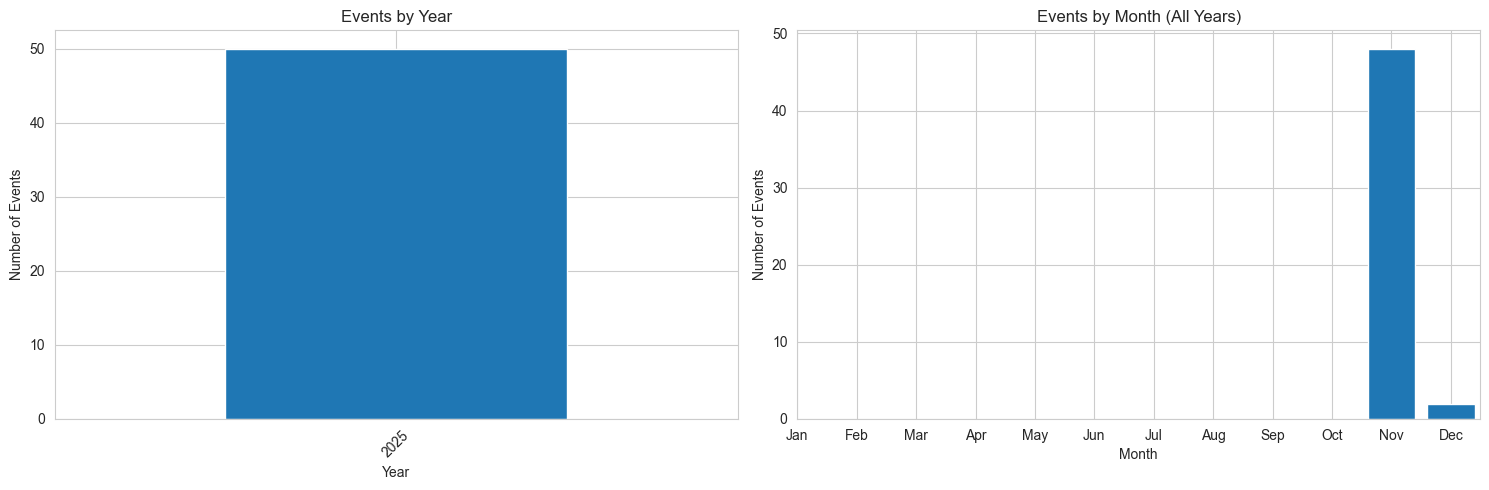

In [7]:
# Convert datetime to pandas datetime
if 'datetime' in df.columns:
    df['datetime_parsed'] = pd.to_datetime(df['datetime'], errors='coerce')
    df['year'] = df['datetime_parsed'].dt.year
    df['month'] = df['datetime_parsed'].dt.month
    df['year_month'] = df['datetime_parsed'].dt.to_period('M')
    
    # Events by year
    yearly_counts = df['year'].value_counts().sort_index()
    
    print("Events by Year:\n")
    print(yearly_counts)
    
    # Visualize
    if len(yearly_counts) > 0:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Yearly trend
        yearly_counts.plot(kind='bar', ax=ax1)
        ax1.set_xlabel('Year')
        ax1.set_ylabel('Number of Events')
        ax1.set_title('Events by Year')
        ax1.tick_params(axis='x', rotation=45)
        
        # Monthly distribution
        monthly_counts = df['month'].value_counts().sort_index()
        month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                      'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
        ax2.bar(monthly_counts.index, monthly_counts.values)
        ax2.set_xticks(range(1, 13))
        ax2.set_xticklabels(month_names)
        ax2.set_xlabel('Month')
        ax2.set_ylabel('Number of Events')
        ax2.set_title('Events by Month (All Years)')
        
        plt.tight_layout()
        plt.show()
else:
    print("Datetime column not found in this dataset")

---

## 5. Data Export

Export the full dataset to CSV format for use in spreadsheet applications or other analysis tools.

### 5.1 CSV Export

In [8]:
# Select specific columns for export
columns_to_export = ['id', 'collection_id', 'datetime', 'monty:country_codes', 
                     'monty:hazard_codes', 'monty:corr_id']

# Filter columns that exist
existing_columns = [col for col in columns_to_export if col in df.columns]

if existing_columns:
    df_subset = df[existing_columns]
    subset_filename = 'gdacs_events_subset.csv'
    df_subset.to_csv(subset_filename, index=False)
    
    print(f"Subset exported to {subset_filename}")
    print(f"   Columns: {existing_columns}")
    print(f"\nSample data:")
    print(df_subset.head())
else:
    print("None of the specified columns exist in the dataset")

Subset exported to gdacs_events_subset.csv
   Columns: ['id', 'collection_id', 'datetime', 'monty:country_codes', 'monty:hazard_codes', 'monty:corr_id']

Sample data:
                    id collection_id              datetime  \
0  gdacs-event-1512717  gdacs-events  2025-12-01T01:41:44Z   
1  gdacs-event-1512711  gdacs-events  2025-12-01T00:48:00Z   
2  gdacs-event-1512706  gdacs-events  2025-11-30T23:16:37Z   
3  gdacs-event-1512681  gdacs-events  2025-11-30T17:25:49Z   
4  gdacs-event-1512673  gdacs-events  2025-11-30T16:23:05Z   

  monty:country_codes             monty:hazard_codes  \
0               [PHL]  [GH0101, EQ, nat-geo-ear-gro]   
1               [JPN]  [GH0101, EQ, nat-geo-ear-gro]   
2               [IDN]  [GH0101, EQ, nat-geo-ear-gro]   
3               [JPN]  [GH0101, EQ, nat-geo-ear-gro]   
4                  []  [GH0101, EQ, nat-geo-ear-gro]   

                monty:corr_id  
0  20251201-PHL-GH0101-1-GCDB  
1  20251201-JPN-GH0101-1-GCDB  
2  20251130-IDN-GH0101-1-GC

---

## 6. Multi-Collection Hazard Code Analysis

This section analyzes the **top 10 most common hazard codes** across multiple data sources (GDACS, EM-DAT, GLIDE) to:
1. Count how many times each hazard code appears
2. Compare hazard code distribution across different collections
3. Identify which disaster types are most common
4. Visualize the results with detailed charts

This helps us understand:
- Which disaster types are most frequently recorded
- How different data sources classify the same disasters
- The overall distribution of hazard events in the database

Hazard Code Analysis

Analyzing hazard codes from multiple data sources...

Collections to analyze: gdacs-events, glide-events

  gdacs-events: 100 items retrieved
  gdacs-events: 100 items retrieved
  glide-events: 100 items retrieved

HAZARD CODE COUNTS

Top 10 Hazard Code Counts:

    Hazard Code            Description  Total Count  GDACS  EM-DAT  GLIDE
         GH0101 Earthquake (UNDRR-ISC)           92     90       0      2
             EQ             Earthquake           92     90       0      2
nat-geo-ear-gro    Earthquake (EM-DAT)           92     90       0      2
nat-hyd-flo-flo      Flooding (EM-DAT)           25      4       0     21
         GH0001                Unknown           24      0       0     24
         GH0002                Unknown           24      0       0     24
         GH0003                Unknown           24      0       0     24
         GH0004                Unknown           24      0       0     24
         GH0005                Unknown           

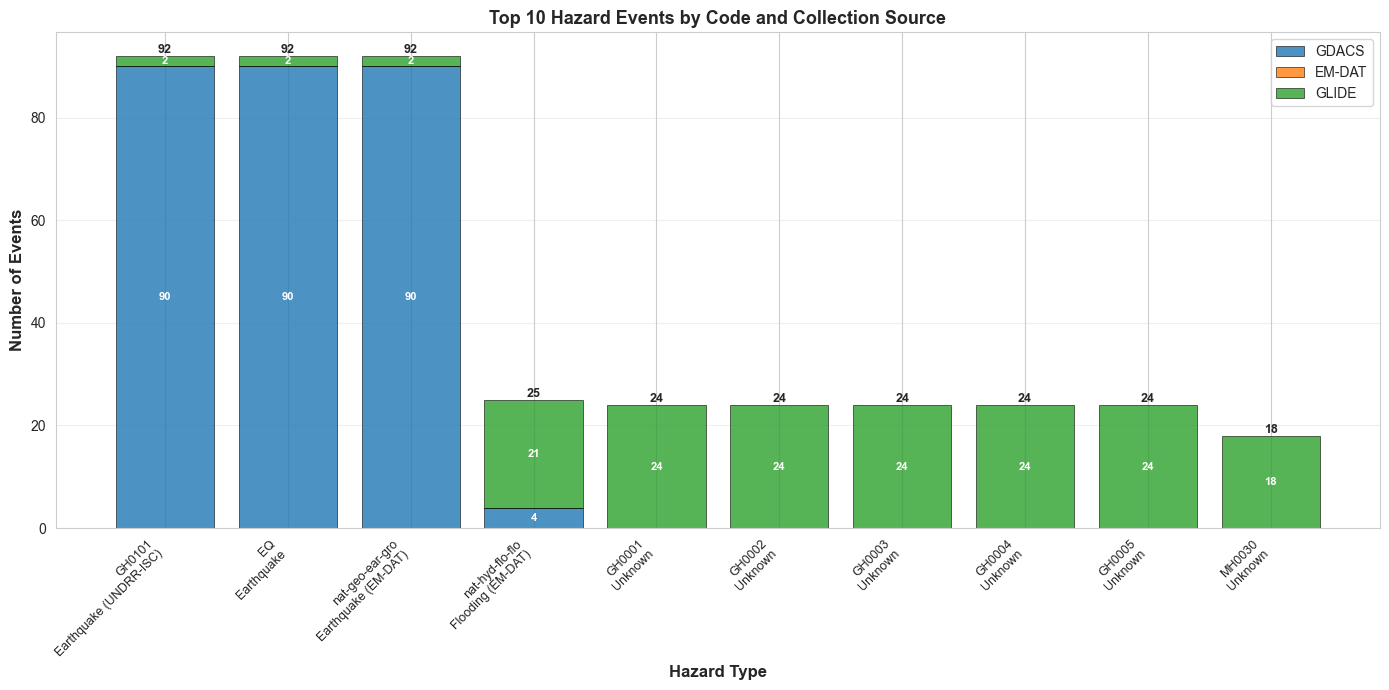


Total Events: 439
Unique Hazard Codes Displayed: 10 (out of 40 total)


In [9]:
# Count hazard codes across all collections
print("Hazard Code Analysis\n")
print("Analyzing hazard codes from multiple data sources...\n")

# Search across multiple collections
disaster_collections = ['gdacs-events', 'glide-events']

print(f"Collections to analyze: {', '.join(disaster_collections)}\n")

# Track hazard codes
hazard_counts = {}  # Track all hazard codes
hazard_by_collection = {}  # Track by collection

for collection in disaster_collections:
    hazard_by_collection[collection] = {}
    try:
        items = search_stac(collections=[collection], limit=100)
        
        # Count hazard codes from all items
        for item in items:
            hazard_codes = item.properties.get('monty:hazard_codes', [])
            
            if isinstance(hazard_codes, list):
                for hazard in hazard_codes:
                    # Count globally
                    hazard_counts[hazard] = hazard_counts.get(hazard, 0) + 1
                    # Count by collection
                    hazard_by_collection[collection][hazard] = hazard_by_collection[collection].get(hazard, 0) + 1
        
        print(f"  {collection}: {len(items)} items retrieved")
    except Exception as e:
        print(f"  {collection}: Error - {str(e)}")

# Create DataFrame of hazard counts
if hazard_counts:
    print("\n" + "="*80)
    print("HAZARD CODE COUNTS")
    print("="*80)
    
    hazard_data = []
    for hazard_code in sorted(hazard_counts.keys(), key=lambda x: hazard_counts[x], reverse=True):
        total_count = hazard_counts[hazard_code]
        description = hazard_descriptions.get(hazard_code, "Unknown")
        
        # Get counts by collection
        collection_counts = {}
        for collection in disaster_collections:
            collection_counts[collection] = hazard_by_collection.get(collection, {}).get(hazard_code, 0)
        
        hazard_data.append({
            'Hazard Code': hazard_code,
            'Description': description,
            'Total Count': total_count,
            'GDACS': collection_counts.get('gdacs-events', 0),
            'EM-DAT': collection_counts.get('emdat-events', 0),
            'GLIDE': collection_counts.get('glide-events', 0),
        })
    
    hazard_df = pd.DataFrame(hazard_data)
    
    # Limit to top 10 hazard codes
    hazard_df_top10 = hazard_df.head(10)
    
    print("\nTop 10 Hazard Code Counts:\n")
    print(hazard_df_top10.to_string(index=False))
    
    # Create visualization
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # Create labels combining code and description (top 10 only)
    labels = [f"{row['Hazard Code']}\n{row['Description']}" for _, row in hazard_df_top10.iterrows()]
    
    # Stacked bar chart by collection
    collections = ['GDACS', 'EM-DAT', 'GLIDE']
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    x_pos = range(len(hazard_df_top10))
    bottom = [0] * len(hazard_df_top10)
    
    for idx, collection in enumerate(collections):
        values = hazard_df_top10[collection].values
        bars = ax.bar(x_pos, values, bottom=bottom, label=collection, 
                     color=colors[idx], edgecolor='black', linewidth=0.5, alpha=0.8)
        
        # Add value labels on bars if significant
        for i, (bar_pos, val) in enumerate(zip(x_pos, values)):
            if val > 0:
                ax.text(bar_pos, bottom[i] + val/2, str(int(val)),
                       ha='center', va='center', fontsize=8, fontweight='bold', color='white')
        
        # Update bottom for stacking
        bottom = [bottom[i] + val for i, val in enumerate(values)]
    
    # Add total count on top
    for i, total in enumerate(hazard_df_top10['Total Count']):
        ax.text(i, bottom[i], str(int(total)), ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    ax.set_xticks(x_pos)
    ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=9)
    ax.set_xlabel('Hazard Type', fontsize=12, fontweight='bold')
    ax.set_ylabel('Number of Events', fontsize=12, fontweight='bold')
    ax.set_title('Top 10 Hazard Events by Code and Collection Source', fontsize=13, fontweight='bold')
    ax.legend(loc='upper right', fontsize=10)
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n{'='*80}")
    print(f"Total Events: {hazard_df_top10['Total Count'].sum()}")
    print(f"Unique Hazard Codes Displayed: {len(hazard_df_top10)} (out of {len(hazard_df)} total)")
else:
    print("\nNo hazard codes found in collections")

---

## 8. Interactive Map Visualization

Create an interactive map showing disaster locations in Europe for the last 3 months across multiple collections (GDACS, EM-DAT, GLIDE).

In [10]:
# Install folium if not already installed

import folium
from folium import plugins
print("Folium already installed")

Folium already installed


---



In [11]:
# Define Europe bounding box and time range
europe_bbox = [-10.0, 35.0, 40.0, 71.0]  # [min_lon, min_lat, max_lon, max_lat]

# Calculate date range (last 120 days)
end_date = datetime.now()
start_date = end_date - timedelta(days=120)
datetime_range = f"{start_date.strftime('%Y-%m-%d')}T00:00:00Z/{end_date.strftime('%Y-%m-%d')}T23:59:59Z"

# Fetch data from all three collections
map_collections = ['gdacs-events', 'emdat-events', 'glide-events']
all_map_items = []

for collection in map_collections:
    try:
        items = search_stac(
            collections=[collection],
            bbox=europe_bbox,
            datetime_range=datetime_range,
            limit=100
        )
        for item in items:
            item.properties['source_collection'] = collection
        all_map_items.extend(items)
    except Exception as e:
        pass

print(f"Total events found: {len(all_map_items)}")

Total events found: 70


In [12]:
# Analyze and extract hazard information from events
def extract_hazard_name(title):
    """Extract hazard name from title by taking text before ' in '"""
    if not title or title == 'No title':
        return 'Unknown'
    hazard_name = title.split(' in ')[0].strip()
    return hazard_name if hazard_name else 'Unknown'

# Build hazard code names mapping from event titles
hazard_code_names = {}
for item in all_map_items:
    hazard_codes = item.properties.get('monty:hazard_codes', [])
    if isinstance(hazard_codes, list):
        for code in hazard_codes:
            if code not in hazard_code_names:
                title = item.properties.get('title', 'No title')
                hazard_code_names[code] = extract_hazard_name(title)

print(f"Extracted {len(hazard_code_names)} unique hazard types from {len(all_map_items)} events")

Extracted 23 unique hazard types from 70 events


In [13]:
# Create interactive map with hazards
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Center map on Europe
europe_center = [50.0, 15.0]
m = folium.Map(
    location=europe_center,
    zoom_start=4,
    tiles='OpenStreetMap'
)

# Define colors for each source collection (outline colors)
source_colors = {
    'gdacs-events': '#1f77b4',      # Blue
    'emdat-events': '#ff7f0e',      # Orange
    'glide-events': '#2ca02c'       # Green
}

# Track which hazard names actually have valid coordinates
hazards_on_map = set()

# First pass: identify which hazard names have valid coordinates
for item in all_map_items:
    if item.geometry and item.geometry.get('coordinates'):
        coords = item.geometry['coordinates']
        if item.geometry['type'] == 'Point':
            lon, lat = coords[0], coords[1]
            hazard_codes = item.properties.get('monty:hazard_codes', [])
            
            if isinstance(hazard_codes, list) and len(hazard_codes) > 0:
                hazard_name = hazard_code_names.get(hazard_codes[0], 'Unknown')
                hazards_on_map.add(hazard_name)

# Generate distinct colors only for hazards that are on the map
unique_hazard_names = sorted(list(hazards_on_map))
num_hazards = len(unique_hazard_names)

if num_hazards > 0:
    cmap = cm.get_cmap('tab20', num_hazards)
    hazard_colors = {}
    for idx, hazard_name in enumerate(unique_hazard_names):
        rgba = cmap(idx)
        hex_color = mcolors.rgb2hex(rgba)
        hazard_colors[hazard_name] = hex_color
else:
    hazard_colors = {}

# Add markers for each event
for item in all_map_items:
    if item.geometry and item.geometry.get('coordinates'):
        coords = item.geometry['coordinates']
        
        if item.geometry['type'] == 'Point':
            lon, lat = coords[0], coords[1]
            
            # Get event details
            title = item.properties.get('title', 'No title')
            hazard_codes = item.properties.get('monty:hazard_codes', [])
            source = item.properties.get('source_collection', 'Unknown')
            
            # Extract hazard name from first code
            hazard_name = 'Unknown'
            if isinstance(hazard_codes, list) and len(hazard_codes) > 0:
                hazard_name = hazard_code_names.get(hazard_codes[0], 'Unknown')
            
            # Get colors
            fill_color = hazard_colors.get(hazard_name, 'gray')
            outline_color = source_colors.get(source, 'black')
            
            # Create popup
            codes_str = ', '.join(hazard_codes) if isinstance(hazard_codes, list) else str(hazard_codes)
            popup_text = f"<b>{title}</b><br>Hazard: {hazard_name}<br>Codes: {codes_str}<br>Source: {source}"
            
            # Add marker
            marker = folium.CircleMarker(
                location=[lat, lon],
                radius=8,
                popup=folium.Popup(popup_text, max_width=300),
                color=outline_color,
                fill=True,
                fillColor=fill_color,
                fillOpacity=0.7,
                weight=2
            )
            marker.add_to(m)

# Add legend for hazard names (fill colors) - only those on the map
hazard_legend_html = '<div style="position: fixed; bottom: 50px; right: 50px; width: 220px; background-color: white; border:2px solid grey; z-index:9999; font-size:12px; padding: 10px; border-radius: 5px;"><h4 style="margin-top:0;">Hazard Types</h4>'
for hazard_name in unique_hazard_names:
    color = hazard_colors.get(hazard_name, 'gray')
    hazard_legend_html += f'<p><i class="fa fa-circle" style="color:{color}"></i> {hazard_name}</p>'
hazard_legend_html += '</div>'

# Add legend for sources (outline colors)
source_legend_html = '<div style="position: fixed; bottom: 50px; left: 50px; width: 220px; background-color: white; border:2px solid grey; z-index:9999; font-size:12px; padding: 10px; border-radius: 5px;"><h4 style="margin-top:0;">Data Sources</h4>'
for source, color in source_colors.items():
    source_name = source.replace('-events', '').upper()
    source_legend_html += f'<p style="border-left: 4px solid {color}; padding-left: 8px;">{source_name}</p>'
source_legend_html += '</div>'

m.get_root().html.add_child(folium.Element(hazard_legend_html))
m.get_root().html.add_child(folium.Element(source_legend_html))

print(f"Map created with {len(all_map_items)} events")
print(f"Hazard types on map: {', '.join(unique_hazard_names)}")
print(f"Sources: {', '.join(source_colors.keys())}")

display(m)

Map created with 70 events
Hazard types on map: Drought, Earthquake, Flood, Forest fires
Sources: gdacs-events, emdat-events, glide-events
